In [1]:
from nilearn import datasets, image, plotting
import numpy as np
import nibabel as nib

julich_ontology_l = datasets.utils._fetch_files(
    datasets.utils._get_dataset_dir('julich_ontology'),
    [
        (
            'julich_ontology_l.xml',
            'https://github.com/NeuroLang/neurolang_data/raw/main/Julich-Brain/WB/22/MPM/'
            'JulichBrain_MPMAtlas_l_N10_nlin2Stdicbm152asym2009c_publicDOI_3f6407380a69007a54f5e13f3c1ba2e6.xml',
            {'move': 'julich_ontology_l.xml'}
        )
    ]
)[0]

julich_ontology_r = datasets.utils._fetch_files(
    datasets.utils._get_dataset_dir('julich_ontology'),
    [
        (
            'julich_ontology_r.xml',
            'https://github.com/NeuroLang/neurolang_data/raw/main/Julich-Brain/WB/22/MPM/'
            'JulichBrain_MPMAtlas_r_N10_nlin2Stdicbm152asym2009c_publicDOI_14622b49a715338ce96e96611d395646.xml',
            {'move': 'julich_ontology_r.xml'}
        )
    ]
)[0]

ontology = datasets.utils._fetch_files(
    datasets.utils._get_dataset_dir('julich_ontology'),
    [
        (
            'jubrain-ontology_22.json',
            'https://github.com/NeuroLang/neurolang_data/raw/main/Julich-Brain/WB/22/jubrain-ontology_22.json',
            {'move': 'jubrain-ontology_22.json'}
        )
    ]
)[0]

def parse_region(elem, id_2_num, father=None, triples=[]):
    name = elem['name']
    if 'labelIndex' in elem:
        if elem['labelIndex'] is not None:
            index = int(elem['labelIndex'])
            if index in id_2_num:
                num = id_2_num[index]
                triples.append((name, num))
            else:
                print(f'Este no esta: {index, name}')
        
    for c in elem['children']:
        parse_region(c, id_2_num, father=name, triples=triples)
        
    return triples


import json
import pandas as pd
import xml.etree.ElementTree as ET

tree = ET.parse(julich_ontology_l)

id_2_num = {}
for a in tree.iter():
    if a.tag == 'Structure':
        num = int(a.attrib['grayvalue'])
        id_ = int(a.attrib['id'])
        id_2_num[id_] = num

tree = ET.parse(julich_ontology_r)

for a in tree.iter():
    if a.tag == 'Structure':
        num = int(a.attrib['grayvalue'])
        id_ = int(a.attrib['id'])
        id_2_num[id_] = num


with open(ontology) as f:
    data = json.load(f)

regions = data['properties']['regions']
for elem in regions:
    triples = parse_region(elem, id_2_num)
    
    for n, r in [
        (13, 'GapMap Frontal-I (GapMap)'),
        (32, 'GapMap Frontal-to-Occipital (GapMap)'),
        (59, 'GapMap Temporal-to-Parietal (GapMap)'),
        (89, 'GapMap Frontal-II (GapMap)'),
        (95, 'GapMap Frontal-to-Temporal (GapMap)')
    ]:
        triples.append((r, n))
        
    f.close()   
    regions = pd.DataFrame(triples, columns=['r_name', 'r_number']).astype({'r_number': 'int32'}).sort_values('r_number')
    regions.drop_duplicates(inplace=True)
    

Este no esta: (237, 'IF (Amygdala)')


In [2]:
regions[regions.r_name.str.contains('IFG')]

,r_name,r_number
49,Area 44 (IFG),64
50,Area 45 (IFG),67


In [3]:
#ifg44_l = datasets.utils._fetch_files(
#    datasets.utils._get_dataset_dir('julich'),
#    [
#        (
#            'ifg44_l.nii.gz',
#            'https://github.com/NeuroLang/neurolang_data/raw/main/Julich-Brain/Area%2044%20(IFG)/7.4/Area-44_l_N10_nlin2MNI152ASYM2009C_7.4_publicP_1a7ee2bd006ecd2b0afec1294b1edc4f.nii.gz',
#            {'move': 'ifg44_l.nii.gz'}
#        )
#    ]
#)[0]

#ifg44_r = datasets.utils._fetch_files(
#    datasets.utils._get_dataset_dir('julich'),
#    [
#        (
#            'ifg44_r.nii.gz',
#            'https://github.com/NeuroLang/neurolang_data/raw/main/Julich-Brain/Area%2044%20(IFG)/7.4/Area-44_r_N10_nlin2MNI152ASYM2009C_7.4_publicP_ecd680988f3750c6003e02836832a9c9.nii.gz',
#             {'move': 'ifg44_r.nii.gz'}
#        )
#    ]
#)[0]

In [4]:
wb22_l = datasets.utils._fetch_files(
    datasets.utils._get_dataset_dir('julich'),
    [
        (
            'wb22_l.nii.gz',
            'https://github.com/NeuroLang/neurolang_data/raw/main/Julich-Brain/WB/22/MPM/'
            'JulichBrain_MPMAtlas_l_N10_nlin2Stdicbm152asym2009c_publicDOI_3f6407380a69007a54f5e13f3c1ba2e6.nii.gz',
            {'move': 'wb22_l.nii.gz'}
        )
    ]
)[0]

wb22_r = datasets.utils._fetch_files(
    datasets.utils._get_dataset_dir('julich'),
    [
        (
            'wb22_r.nii.gz',
            'https://github.com/NeuroLang/neurolang_data/raw/main/Julich-Brain/WB/22/MPM/'
            'JulichBrain_MPMAtlas_r_N10_nlin2Stdicbm152asym2009c_publicDOI_14622b49a715338ce96e96611d395646.nii.gz',
            {'move': 'wb22_r.nii.gz'}
        )
    ]
)[0]

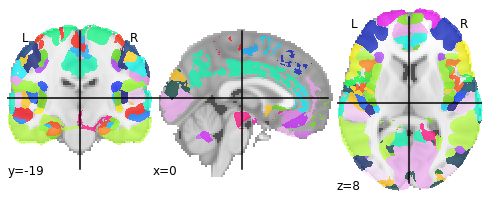

In [5]:
img_r = image.load_img(wb22_r)
img_l = image.load_img(wb22_l)
img_l_data = img_l.get_fdata()
img_r_data = img_r.get_fdata()
img_l_unmaskes = np.nonzero(img_l_data)

for v in zip(*img_l_unmaskes):
    value = img_l_data[v[0]][v[1]][v[2]]
    ex_value = img_r_data[v[0]][v[1]][v[2]]
    if ex_value == 0:
        img_r_data[v[0]][v[1]][v[2]] = value
    
conc_img = nib.spatialimages.SpatialImage(img_r_data, img_r.affine)
plotting.plot_roi(conc_img)

In [6]:
mni_t1 = nib.load(datasets.fetch_icbm152_2009()['t1'])
mni_t1_4mm = image.resample_img(mni_t1, np.eye(3) * 4)

conc_img = image.resample_img(
    conc_img, mni_t1_4mm.affine, interpolation='nearest'
)

conc_img_data = conc_img.get_fdata()
conc_img_unmaskes = np.nonzero(conc_img_data)

julich_brain = []
for v in zip(*conc_img_unmaskes):
    julich_brain.append((v[0], v[1], v[2], conc_img_data[v[0]][v[1]][v[2]]))

In [7]:
d = conc_img.get_fdata()
mask = d != 64
d[mask] = 0
wb = nib.spatialimages.SpatialImage(d, conc_img.affine)

In [8]:
mask = wb.get_fdata() > 0
labels = wb.get_fdata()[mask]
len(labels)

172

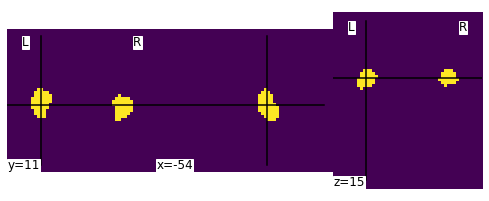

In [9]:
from scipy.ndimage import binary_dilation
import nibabel as nib

new_img = nib.spatialimages.SpatialImage(
    binary_dilation(wb.get_fdata()), 
    wb.affine
)

plotting.plot_img(new_img)

In [10]:
import numpy as np

jl_data = new_img.get_fdata()
jl_unmaskes = np.nonzero(jl_data)

xyz_to_jl_region = []
for v in zip(*jl_unmaskes):
    xyz_to_jl_region.append(tuple(v))

In [11]:
cogAt = datasets.utils._fetch_files(
    datasets.utils._get_dataset_dir('CogAt'),
    [
        (
            'cogat.xml',
            'http://data.bioontology.org/ontologies/COGAT/download?'
            'apikey=8b5b7825-538d-40e0-9e9e-5ab9274a9aeb&download_format=rdf',
            {'move': 'cogat.xml'}
        )
    ]
)[0]

In [12]:
from neurolang.frontend import probabilistic_frontend as pfe

nl = pfe.ProbabilisticFrontend()
nl.load_ontology(cogAt)

j_brain = nl.add_tuple_set(
    julich_brain,
    name='julich_brain'
)

j_regions = nl.add_tuple_set(
    regions.values,
    name='julich_regions'
)

dilated_ifg44 = nl.add_tuple_set(
    tuple(xyz_to_jl_region),
    name='dilated_ifg44'
)

/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.feature_selection.univariate_selection module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


In [13]:
 with nl.scope as e:

    e.local_areas[e.area] = (
        e.julich_brain[e.i, e.j, e.k, e.id] &
        e.dilated_ifg44[e.i, e.j, e.k,] &
        e.julich_regions[e.area, e.id]
    )
    
    res = nl.solve_all()
    local_areas = res['local_areas'].as_pandas_dataframe()


/Users/gzanitti/Projects/INRIA/NeuroLang/neurolang/datalog/aggregation.py:152: UserWarning: No check performed. Should implement check for stratified aggregation
  "No check performed. Should implement check for stratified"


In [14]:
local_areas.area.unique()

array(['Area OP4 (POperc)', 'Area 3b (PostCG)',
       'Area OP6 (Frontal Operculum)', 'Area 44 (IFG)',
       'GapMap Frontal-II (GapMap)', 'Area 45 (IFG)',
       'Subiculum (Hippocampus)', 'Area OP9 (Frontal Operculum)',
       'Area Id6 (Insula)', 'Area OP8 (Frontal Operculum)',
       'Area TeI (STG)', 'Area TE 3 (STG)'], dtype=object)

In [15]:
for v in zip(*img_l_unmaskes):
    value = img_l_data[v[0]][v[1]][v[2]]
    ex_value = img_r_data[v[0]][v[1]][v[2]]
    if ex_value == 0:
        img_r_data[v[0]][v[1]][v[2]] = value
    
conc_img = nib.spatialimages.SpatialImage(img_r_data, img_r.affine)

mask = conc_img.get_fdata() > 0
labels = np.unique(conc_img.get_fdata()[mask])
print(labels)
print()
print(len(labels))

[  1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.
  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.  56.
  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.  70.
  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.  84.
  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.  98.
  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111. 112.
 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124.]

124


In [16]:
print(regions.r_number.unique())
print()
print(len(regions.r_number.unique()))

[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124]

124


In [17]:
print(set(labels) - set(regions.r_number.unique()))
print(set(regions.r_number.unique()) - set(labels))

set()
set()


In [18]:
# Remover Etiqueta 103.0
regions = regions[regions.r_number != 103]

In [19]:
from nilearn.input_data import NiftiLabelsMasker
from nilearn.connectome import ConnectivityMeasure

masker = NiftiLabelsMasker(labels_img=conc_img, standardize=True)
connectome_measure = ConnectivityMeasure(kind='correlation')

data = datasets.fetch_development_fmri(n_subjects=30)

time_series = []
for func, confounds in zip(data.func, data.confounds):
    time_series.append(masker.fit_transform(func, confounds=confounds))

# calculate correlation matrices across subjects and display
correlation_matrices = connectome_measure.fit_transform(time_series)[0]

/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/nilearn/plotting/matrix_plotting.py:13: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  ax.figure.transFigure).width
/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/nilearn/plotting/matrix_plotting.py:21: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  ax.figure.transFigure).height


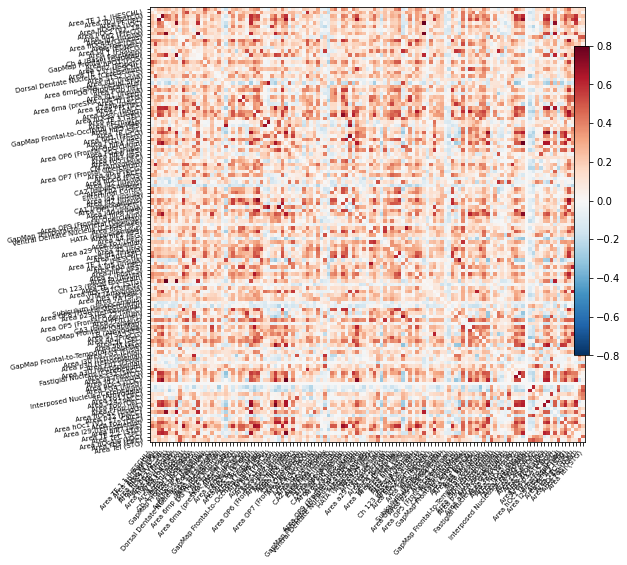

In [20]:
# Display the correlation matrix
import numpy as np
from nilearn import plotting
import matplotlib.pyplot as plt

# Mask out the major diagonal
np.fill_diagonal(correlation_matrices, 0)
plotting.plot_matrix(correlation_matrices, labels=regions.r_name.values, colorbar=True, vmax=0.8, vmin=-0.8, figure=(10, 8))


In [21]:
regions[regions.r_name == 'Area 44 (IFG)']

,r_name,r_number
49,Area 44 (IFG),64


In [22]:
area_44_con = correlation_matrices[63]

In [23]:
regions['r_name'] = regions.r_name.apply(lambda x: x.replace('.', ''))

In [24]:
corr44 = pd.DataFrame(zip(area_44_con, regions.r_name.values, regions.r_number.values), columns=['corr', 'r_name', 'r_number'])


In [25]:
corr44[corr44['corr'] >= corr44['corr'].quantile(.95)].sort_values('corr', ascending=False)

,corr,r_name,r_number
66,0.583585,Area 45 (IFG),67
30,0.580243,Area PFcm (IPL),31
54,0.560589,Area OP1 (POperc),55
57,0.535129,Area OP9 (Frontal Operculum),58
118,0.514830,Area TE 22 (STG),120
37,0.503095,Area OP6 (Frontal Operculum),38
103,0.491945,Area Id7 (Insula),105


In [26]:
for l in local_areas.area.unique():
    corr44 = corr44[corr44.r_name != l]

In [27]:
long_regions = corr44[corr44['corr'] >= corr44['corr'].quantile(.95)].sort_values('corr', ascending=False)

In [28]:
long_regions

,corr,r_name,r_number
30,0.580243,Area PFcm (IPL),31
54,0.560589,Area OP1 (POperc),55
118,0.514830,Area TE 22 (STG),120
103,0.491945,Area Id7 (Insula),105
62,0.464436,Area hIP2 (IPS),63
94,0.450681,GapMap Frontal-to-Temporal (GapMap),95


In [29]:
long_regions = long_regions[['r_name', 'r_number']]
long_regions = long_regions.append(regions[regions.r_name == 'Area 44 (IFG)'])

In [30]:
long_areas = nl.add_tuple_set(
    long_regions.values,
    name='long_areas'
)

In [31]:
long_regions.head(20)

,r_name,r_number
30,Area PFcm (IPL),31
54,Area OP1 (POperc),55
118,Area TE 22 (STG),120
103,Area Id7 (Insula),105
62,Area hIP2 (IPS),63
94,GapMap Frontal-to-Temporal (GapMap),95
49,Area 44 (IFG),64


In [32]:
ns_database_fn, ns_features_fn = datasets.utils._fetch_files(
    datasets.utils._get_dataset_dir('neurosynth'),
    [
        (
            'database.txt',
            'https://github.com/neurosynth/neurosynth-data/raw/master/current_data.tar.gz',
            {'uncompress': True}
        ),
        (
            'features.txt',
            'https://github.com/neurosynth/neurosynth-data/raw/master/current_data.tar.gz',
            {'uncompress': True}
        ),
    ]
)

ns_database = pd.read_csv(ns_database_fn, sep=f'\t')
ijk_positions = (
    np.round(nib.affines.apply_affine(
        np.linalg.inv(mni_t1_4mm.affine),
        ns_database[['x', 'y', 'z']].values.astype(float)
    )).astype(int)
)
ns_database['i'] = ijk_positions[:, 0]
ns_database['j'] = ijk_positions[:, 1]
ns_database['k'] = ijk_positions[:, 2]

ns_features = pd.read_csv(ns_features_fn, sep=f'\t')
ns_docs = ns_features[['pmid']].drop_duplicates()
ns_terms = (
    pd.melt(
            ns_features,
            var_name='term', id_vars='pmid', value_name='TfIdf'
       )
    .query('TfIdf > 1e-3')[['pmid', 'term']]
)

activations = nl.add_tuple_set(ns_database.values, name='activations')
terms = nl.add_tuple_set(ns_terms.values, name='terms')
docs = nl.add_uniform_probabilistic_choice_over_set(
        ns_docs.values, name='docs'
)

from rdflib import RDFS

part_of = nl.new_symbol(name='http://www.obofoundry.org/ro/ro.owl#part_of')
subclass_of = nl.new_symbol(name=str(RDFS.subClassOf))
label = nl.new_symbol(name=str(RDFS.label))
hasTopConcept = nl.new_symbol(name='http://www.w3.org/2004/02/skos/core#hasTopConcept')

In [33]:
@nl.add_symbol
def word_lower(name: str) -> str:
    return name.lower()

In [37]:
with nl.scope as e:
    e.ontology_terms[e.onto_name] = (
        hasTopConcept[e.uri, e.cp] &
        label[e.uri, e.onto_name]
    )

    e.filtered_terms[e.lower_name] = (
        e.ontology_terms[e.term] &
        (e.lower_name == word_lower[e.term])
    )
    

    e.long_regions[e.d, e.id] = (
        e.long_areas[e.area, e.id] &
        e.julich_brain[e.i, e.j, e.k, e.id] &
        e.activations[
            e.d, ..., ..., ..., ..., 'MNI', ..., ..., ..., ...,
            ..., ..., ..., e.i, e.j, e.k
        ]
    )
    
    #e.long_network[e.d, e.id1] = (
    #    e.long_regions[e.d, e.id1] &
    #    e.long_regions[e.d, e.id2] &
    #    (e.id1 != e.id2)
    #)

    e.term_prob[e.t, e.PROB[e.t]] = (
        e.long_regions[e.d, e.id1] & 
        e.long_regions[e.d, e.id2]
        & e.terms[e.d, e.t]
        & e.docs[e.d] &
        (e.id1 != e.id2)
    )

    e.result[e.term, e.PROB] = (
        e.filtered_terms[e.term] &
        e.term_prob[e.term, e.PROB]
    )
    
    res_long = nl.solve_all()


/Users/gzanitti/Projects/INRIA/NeuroLang/neurolang/datalog/aggregation.py:152: UserWarning: No check performed. Should implement check for stratified aggregation
  "No check performed. Should implement check for stratified"
/Users/gzanitti/Projects/INRIA/NeuroLang/neurolang/datalog/aggregation.py:152: UserWarning: No check performed. Should implement check for stratified aggregation
  "No check performed. Should implement check for stratified"


In [38]:
c = res_long['result']._container.copy()
c[c['PROB'] >= c['PROB'].quantile(.99)].sort_values('PROB', ascending=False)

,term,PROB
118,memory,1.468235
104,attention,0.913228


In [ ]:
with nl.scope as e:
    e.ontology_terms[e.onto_name] = (
        hasTopConcept[e.uri, e.cp] &
        label[e.uri, e.onto_name]
    )

    e.filtered_terms[e.lower_name] = (
        e.ontology_terms[e.term] &
        (e.lower_name == word_lower[e.term])
    )

    e.local_regions[e.d, e.id] = (
        e.dilated_ifg44[e.i, e.j, e.k,] &
        e.julich_regions[e.area, e.id] &
        e.julich_brain[e.i, e.j, e.k, e.id] &
        e.activations[
            e.d, ..., ..., ..., ..., 'MNI', ..., ..., ..., ...,
            ..., ..., ..., e.i, e.j, e.k
        ]
    )
    
    e.local_network[e.d, e.id1] = (
        e.local_regions[e.d, e.id1] &
        e.local_regions[e.d, e.id2] &
        (e.id1 != e.id2)
    )

    e.term_prob[e.t, e.PROB[e.t]] = (
        e.local_network[e.d, e.id]
        & e.terms[e.d, e.t]
        & e.docs[e.d]
    )

    e.result[e.term, e.PROB] = (
        e.filtered_terms[e.term] &
        e.term_prob[e.term, e.PROB]
    )
    
    res_local = nl.solve_all()


In [ ]:
c = res_local['result']._container.copy()
c[c['PROB'] >= c['PROB'].quantile(.99)].sort_values('PROB', ascending=False)